# Bandit Task 1

This script will create an Active Inference agent of the bandit task implemented by Sumner et al. (2019) to analyse developmental differences in explore-exploit behavior between children and adults. 

http://mstrep.s3.amazonaws.com/publications/SumnerSteyversSarneckaCogsci2019.pdf

The scripts follow the outline proposed by Conor Heins. This involves defining the agents generative Model in the form of Numpy arrays (A, B, C, D, E) and creating an environment (the generative process) in the form of a step function.

https://colab.research.google.com/drive/1TQjRhCBHPeZd9vTktlp5sx00GeQEjZHf?usp=sharing#scrollTo=LjxoLs67AXwR


In [2]:
import numpy as np 
import pymdp  
from pymdp import utils , maths 
from pymdp.agent import Agent
import matplotlib.pyplot as plt
from pymdp.maths import softmax
import random

In [58]:
# This defines the possible space of actions, rewards and states the agent can infer. Choosing the states is a bit tricky and I'm not sure about this.
# Here the agent has 3 machines to choose from and thus infers in which of 6 (3!) states it is in. Inferring over 3 states (which machine is the best) also works
# computationally. This has to be reasoned with regards to the task instructions the participants were given.

context_names = ['Left-Middle-Right', 'Left-Right-Middle', 'Middle-Left-Right', 'Middle-Right-Left', 'Right-Left-Middle', 'Right-Middle-Left']
choice_names = ['Start', 'Left Arm', 'Middle Arm', 'Right Arm']

num_states = [len(context_names), len(choice_names)]
num_factors = len(num_states)

context_action_names = ['Do-nothing']
choice_action_names = ['Move-start', 'Play-Left', 'Play-Middle', 'Play-Right']

num_controls = [len(context_action_names), len(choice_action_names)]

reward_obs_names = ['Null', 'Reward', 'Loss']
choice_obs_names = ['Start', 'Left Arm', 'Middle Arm', 'Right Arm']


num_obs = [len(reward_obs_names), len(choice_obs_names)]
num_modalities = len(num_obs)



To create the A-arrays (observation likelihood) I randomly create a winning probability over 50% for the agent to assume if the 
chosen behavior refers to a state where the respective machine is thought to be the most rewarding. A second winrate lower than the first one is created for when the behavior refers to a state, in which the respective machine is thought to be the second most rewarding. This is a bit arbitrary, as the participants were not asked about their initial beliefs about the reward contingencies of the task. 


In [59]:

pWin = random.uniform(0.5, 1)
pWin2 = random.uniform(0, pWin)

# A[0] refers to the reward/loss observation modality. Each row is an observation (null, reward, loss) and each column represents a context. 
# The slices represent the different behaviors.

A = utils.initialize_empty_A(num_obs, num_states)
A[0] = np.zeros((3,6,4))

#start
A[0][:,:,0] = np.array([[1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

#choose left
A[0][:,:,1] = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [pWin, pWin, pWin2, 1-pWin, pWin2, 1-pWin],
                        [1-pWin, 1-pWin, 1-pWin2, pWin, 1-pWin2, pWin]])
#choose middle
A[0][:,:,2] = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [pWin2, 1-pWin, pWin, pWin, 1-pWin, pWin2],
                        [1-pWin2, pWin, 1-pWin, 1-pWin, pWin, 1-pWin2]])
#choose right
A[0][:,:,3] = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [1-pWin, pWin2, 1-pWin, pWin2, pWin, pWin],
                        [pWin, 1-pWin2, pWin, 1-pWin2, 1-pWin, 1-pWin]])

# A[1] refers to the choice observation modality. It serves as a GPS for the agent and in this case the agent always knows its behavior
# with certainty.

A[1] = np.zeros((4,6,4))

#start
A[1][:,:,0] = np.array([[1.0, 1.0, 1.0, 1.0, 1.0, 1.0],         #start
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],         #choose left
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],         #choose middle
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])        #choose right

A[1][:,:,1]=  np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],         
                        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],         
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],         
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]) 

A[1][:,:,2]=  np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],         
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],         
                        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],         
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]) 


A[1][:,:,3]=  np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],         
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],         
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],         
                        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]) 


In [60]:
print(A[0][:,:,0])

print(A[0][:,:,1])

print(A[0][:,:,2])

print(A[0][:,:,3])

[[1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0.         0.         0.         0.         0.         0.        ]
 [0.71643565 0.71643565 0.08575796 0.28356435 0.08575796 0.28356435]
 [0.28356435 0.28356435 0.91424204 0.71643565 0.91424204 0.71643565]]
[[0.         0.         0.         0.         0.         0.        ]
 [0.08575796 0.28356435 0.71643565 0.71643565 0.28356435 0.08575796]
 [0.91424204 0.71643565 0.28356435 0.28356435 0.71643565 0.91424204]]
[[0.         0.         0.         0.         0.         0.        ]
 [0.28356435 0.08575796 0.28356435 0.08575796 0.71643565 0.71643565]
 [0.71643565 0.91424204 0.71643565 0.91424204 0.28356435 0.28356435]]


The B-array describes how the states (contexts, choices) evolve from one timepoint to another given the agents choices. B[0] denotes the context states and essentially that the agent thinks it can't change the context (which is true). B[1] denotes the 'accuracy' with which the agent thinks he executes his choices.

In [61]:
def create_B():
  B = utils.initialize_empty_B(num_states, num_states)
  B_context = np.zeros( (len(context_names), len(context_names), len(context_action_names)) )
  B_context[:,:,0] = np.array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                               [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                               [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                               [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                               [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                               [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
  
  """ Choice transitions (controllable) """
  B_choice = np.zeros( (len(choice_names), len(choice_names), len(choice_action_names)) )
  for choice_i in range(len(choice_names)):
    B_choice[choice_i, :, choice_i] = 1.0

  B[0], B[1] = B_context, B_choice

  return B

B = create_B()

In [62]:
print(B[0][:,:,0])

print(B[1][:,:,0])

[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
[[1. 1. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


The C-array contains the agents preferences for observation. In Active Inference, agents aim to minimize variational Free Energy, which is an upper bound on surprisal (-ln p(o). Thus, defining the agents preferences involves creating a prior over observation as the agent seeks out, what it expects (more or less). Here, the agent shows a preference for the reward condition and is adverse towards the loss observation. It has no preference on any of the choice observations themselves. 

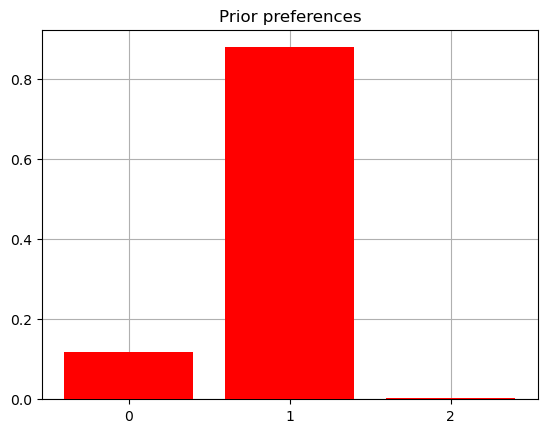

In [63]:
def create_C(reward=2.0, pun=-4):

  C = utils.obj_array_zeros(num_obs)
  C[0] = np.array([0., reward, pun])
  return C

C = create_C(reward=2.0, pun=-4.0)


utils.plot_beliefs(softmax(C[0]), title = "Prior preferences")

utils.plot_beliefs(softmax(C[1]), title = "Prior preferences")


The D-array encodes the agents prior belief about the state it is in at the beginning of the task. A reasonable choice is a uniform prior. The agent assumes all of the 6 possible states to be equally likely. 

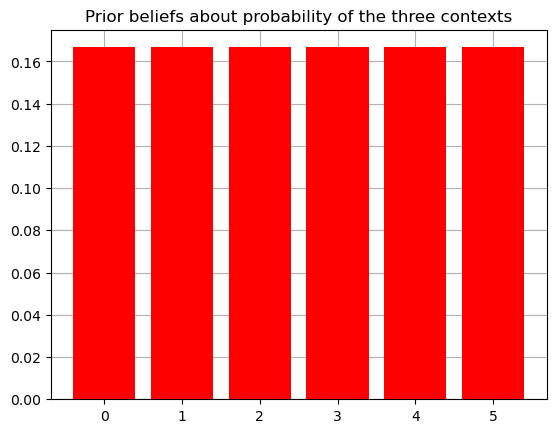

In [64]:
D = utils.obj_array(num_factors)

D[0] = np.array([2/12, 2/12, 2/12, 2/12, 2/12, 2/12])

D[1] = np.array([1.0, 0.0, 0.0, 0.0])

utils.plot_beliefs(softmax(D[0]), title = "Prior beliefs about probability of the three contexts")

The E-array contains a prior over choices, that is independent of the priors over observations (C) or the prior over contexts (D). Here, the agent has no preference for any of the choices, but creating a bias towards one choice option could somewhat be interpreted as a habit.

In [65]:
E = np.array([0, 2/6, 2/6, 2/6])

The next section defines the environment for the agent to interact with. It involves initiating the different contexts and rewards and then a step function that defines how the environment reacts to the agents behavior. Here, these reactions (i.e. the reward contingencies) are cleary defined. The agent always gets a reward for choosing the left machine, never for choosing the right machine and half the time for choosing the middle machine. 

In [ ]:
class BanditTask(object):

    def __init__(self, context=None):
        self.context_names = ['Left-Middle-Right', 'Left-Right-Middle', 'Middle-Left-Right', 'Middle-Right-Left', 'Right-Left-Middle', 'Right-Middle-Left']
        self.context = context
        self.reward_obs_names = ['Null', 'Reward', 'Loss']
    def step(self, action):
        if action == "Move-start":
            observed_reward = "Null"
            observed_choice = "Start"
        elif action == "Play-Left":
            observed_choice = "Left Arm"
            observed_reward = "Reward"
        elif action == "Play-Middle":
            observed_choice = "Middle Arm"
            flip = random.randint(0,1)
            if flip == 0:
                observed_reward = 'Loss'
            else:
                observed_reward = 'Reward'
        elif action == "Play-Right":
            observed_choice = "Right Arm"
            observed_reward = 'Loss'
        else:
            observed_reward = "Null"
            observed_choice = "Null"

        obs = [observed_reward, observed_choice]
        return obs


The next section creates the active inference loops. The agent begins by sampling an initial observation and then infers in which states it is in based on the observation (qs). It then computes the expected free energy (efe) for each policy and then selects an action, which leads to an observation. This process is repeated for each trial.

In [71]:
def run_active_inference_loop(my_agent, my_env, T = 5, verbose = False):
  obs_label = ["Null", "Start"]  # agent observes itself  getting a `Null` reward, and seeing itself in the `Start` location
  obs = [reward_obs_names.index(obs_label[0]), choice_obs_names.index(obs_label[1])]

  first_choice = choice_obs_names.index(obs_label[1])
  choice_hist = np.zeros((4,T+1))
  choice_hist[first_choice,0] = 1.0

  belief_hist = np.zeros((6, T))
  context_hist = np.zeros(T)

  for t in range(T):
    context_hist[t] = env.context_names.index(env.context)
    qs = my_agent.infer_states(obs)
    print(f'qs:{qs}')

    belief_hist[:,t] = qs[0]

    if verbose:
      utils.plot_beliefs(qs[0], title = f"Beliefs about the context at time {t}")

    q_pi, efe = my_agent.infer_policies()
    print(f'efe:{efe}')
    chosen_action_id = my_agent.sample_action()

    movement_id = int(chosen_action_id[1])
    choice_hist[movement_id,t+1]= 1.0

    choice_action = choice_action_names[movement_id]
    
    print(f'action choice : {choice_action}')

    obs_label = my_env.step(choice_action)
    #print(f'obs_label {obs_label}')
    
    obs = [reward_obs_names.index(obs_label[0]), choice_obs_names.index(obs_label[1])]

    if verbose:
      print(f'Action at time {t}: {choice_action}')
      print(f'Reward at time {t}: {obs_label[0]}')

  return choice_hist, belief_hist, context_hist


In [72]:
def plot_choices_beliefs(choice_hist, belief_hist, context_hist, pad_val=5.0):
  T = choice_hist.shape[1]
  fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (14,11))
  axes[0].imshow(choice_hist[:,:-1], cmap = 'gray') # only plot up until the second to last timestep, since we don't update beliefs after the last choice
  axes[0].set_xlabel('Timesteps')
  axes[0].set_yticks(ticks = range(4))
  axes[0].set_yticklabels(labels = choice_action_names)
  axes[0].set_title('Choices over time')

  axes[1].imshow(belief_hist, cmap = 'gray')
  axes[1].set_xlabel('Timesteps')
  axes[1].set_yticks(ticks = range(6))
  axes[1].set_yticklabels(labels = ['Left-Middle_Right', 'Left-Right-Middle', 'Middle-Left-Right', 'Middle-Right-Left', 'Right-Left-Middle', 'Right-Middle-Left'])
  axes[1].set_title('Beliefs over time')
  axes[1].scatter(np.arange(T-1), context_hist, c = 'r', s = 50)

  fig.tight_layout(pad=pad_val)
  plt.show()


qs:[array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667])
 array([1.e+00, 1.e-32, 1.e-32, 1.e-32])]


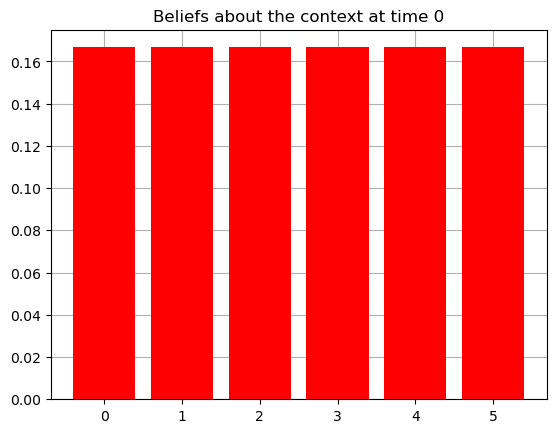

efe:[-3.51540316 -5.18443542 -5.18443542 -5.18443542]
action choice : Play-Left
Action at time 0: Play-Left
Reward at time 0: Reward
qs:[array([0.3299242 , 0.3299242 , 0.03949221, 0.13058359, 0.03949221,
        0.13058359])
 array([2.10264148e-32, 1.00000000e+00, 2.10264148e-32, 2.10264148e-32])]


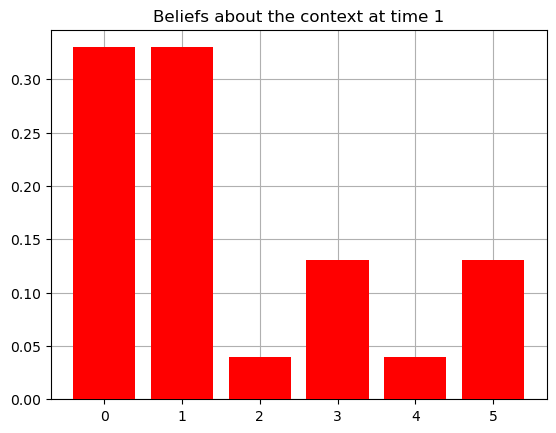

efe:[-3.51540316 -4.07888801 -5.79594766 -5.79594766]
action choice : Play-Left
Action at time 1: Play-Left
Reward at time 1: Reward
qs:[array([0.42699097, 0.42699097, 0.00611805, 0.06689098, 0.00611805,
        0.06689098])
 array([1.62163821e-32, 1.00000000e+00, 1.62163821e-32, 1.62163821e-32])]


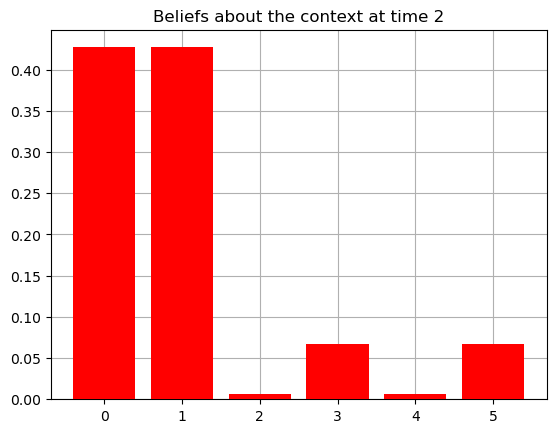

efe:[-3.51540316 -3.55618119 -6.13316852 -6.13316852]
action choice : Play-Left
Action at time 2: Play-Left
Reward at time 2: Reward
qs:[array([0.47004867, 0.47004867, 0.00080618, 0.02914514, 0.00080618,
        0.02914514])
 array([1.47833407e-32, 1.00000000e+00, 1.47833407e-32, 1.47833407e-32])]


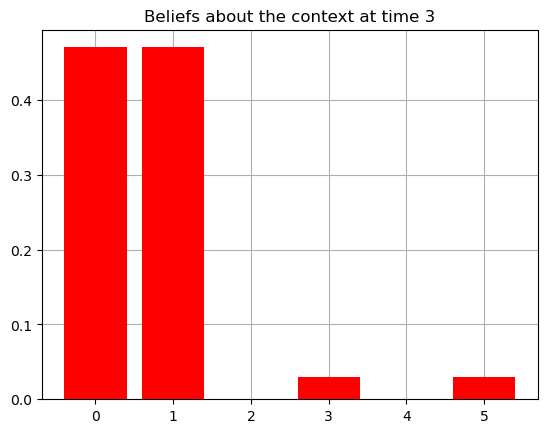

efe:[-3.51540316 -3.35113093 -6.2760664  -6.2760664 ]
action choice : Play-Left
Action at time 3: Play-Left
Reward at time 3: Reward
qs:[array([4.87925497e-01, 4.87925497e-01, 1.00171100e-04, 1.19743314e-02,
        1.00171100e-04, 1.19743314e-02])
 array([1.42773451e-32, 1.00000000e+00, 1.42773451e-32, 1.42773451e-32])]


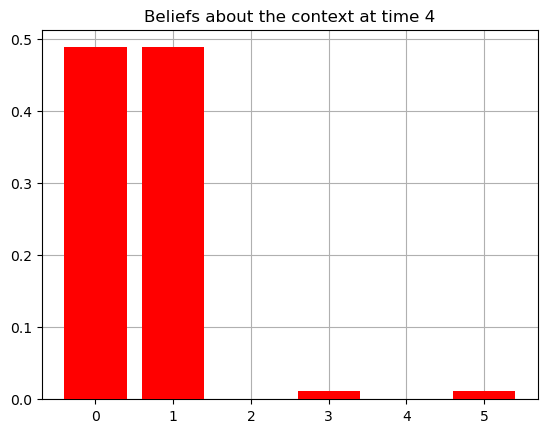

efe:[-3.51540316 -3.27023009 -6.33434842 -6.33434842]
action choice : Play-Left
Action at time 4: Play-Left
Reward at time 4: Reward
qs:[array([4.95177959e-01, 4.95177959e-01, 1.21687919e-05, 4.80987185e-03,
        1.21687919e-05, 4.80987185e-03])
 array([1.40837219e-32, 1.00000000e+00, 1.40837219e-32, 1.40837219e-32])]


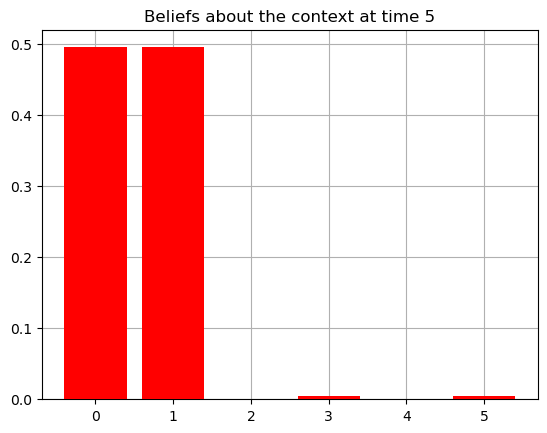

efe:[-3.51540316 -3.23802765 -6.35787424 -6.35787424]
action choice : Play-Left
Action at time 5: Play-Left
Reward at time 5: Reward
qs:[array([4.98083622e-01, 4.98083622e-01, 1.46516202e-06, 1.91491236e-03,
        1.46516202e-06, 1.91491236e-03])
 array([1.40077091e-32, 1.00000000e+00, 1.40077091e-32, 1.40077091e-32])]


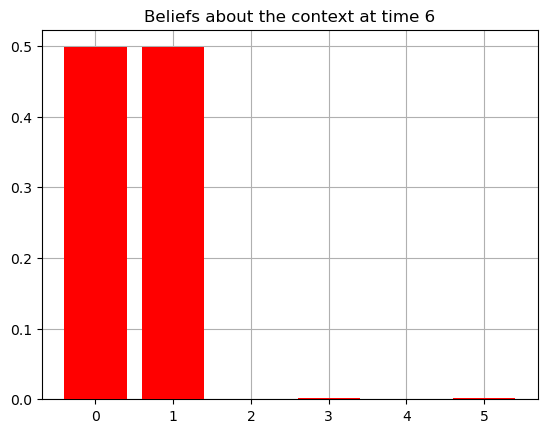

efe:[-3.51540316 -3.22521477 -6.36728923 -6.36728923]
action choice : Play-Left
Action at time 6: Play-Left
Reward at time 6: Reward
qs:[array([4.99240144e-01, 4.99240144e-01, 1.75788364e-07, 7.59679803e-04,
        1.75788364e-07, 7.59679803e-04])
 array([1.39974244e-32, 1.00000000e+00, 1.39974244e-32, 1.39974244e-32])]


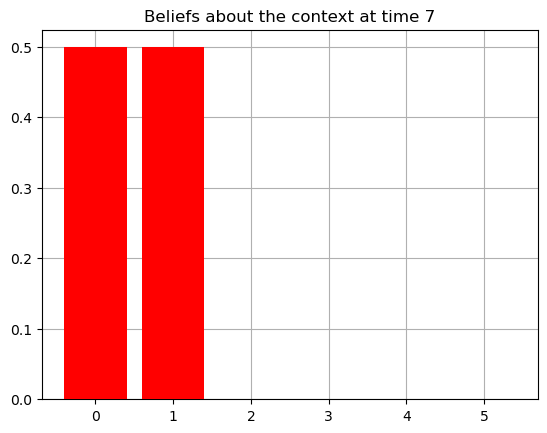

efe:[-3.51540316 -3.22012777 -6.37103604 -6.37103604]
action choice : Play-Left
Action at time 7: Play-Left
Reward at time 7: Reward
qs:[array([4.99699022e-01, 4.99699022e-01, 2.10613573e-08, 3.00956703e-04,
        2.10613573e-08, 3.00956703e-04])
 array([1.3973598e-32, 1.0000000e+00, 1.3973598e-32, 1.3973598e-32])]


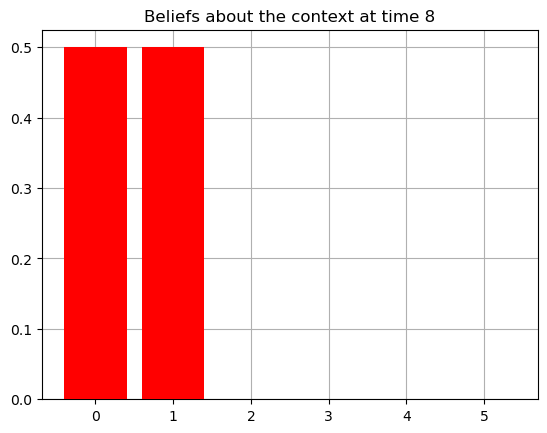

efe:[-3.51540312 -3.21811124 -6.37252269 -6.37252269]
action choice : Play-Left
Action at time 8: Play-Left
Reward at time 8: Reward
qs:[array([4.99880836e-01, 4.99880836e-01, 2.52197964e-09, 1.19161633e-04,
        2.52197964e-09, 1.19161633e-04])
 array([1.3964167e-32, 1.0000000e+00, 1.3964167e-32, 1.3964167e-32])]


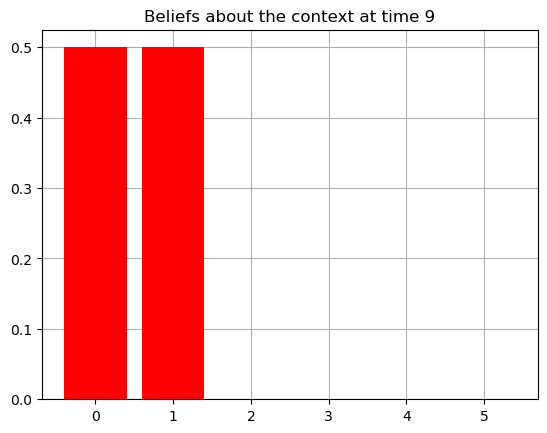

efe:[-3.51540315 -3.21731254 -6.37311178 -6.37311178]
action choice : Play-Left
Action at time 9: Play-Left
Reward at time 9: Reward
qs:[array([4.99952829e-01, 4.99952829e-01, 3.01926594e-10, 4.71708205e-05,
        3.01926594e-10, 4.71708205e-05])
 array([1.39604336e-32, 1.00000000e+00, 1.39604336e-32, 1.39604336e-32])]


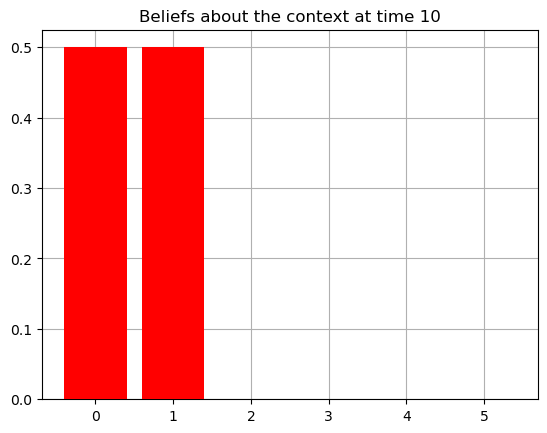

efe:[-3.51540316 -3.21699632 -6.37334504 -6.37334504]
action choice : Play-Left
Action at time 10: Play-Left
Reward at time 10: Reward
qs:[array([4.99981329e-01, 4.99981329e-01, 3.61429420e-11, 1.86712170e-05,
        3.61429420e-11, 1.86712170e-05])
 array([1.39589558e-32, 1.00000000e+00, 1.39589558e-32, 1.39589558e-32])]


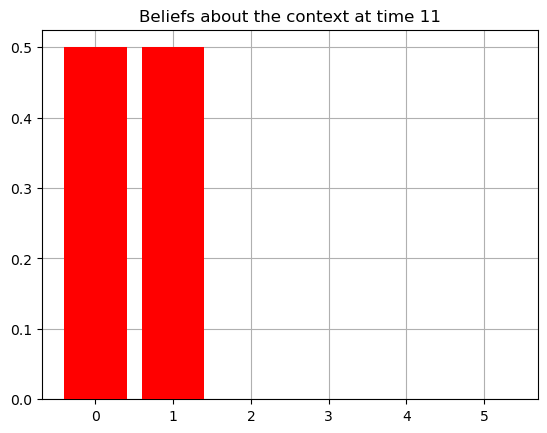

efe:[-3.51540316 -3.21687115 -6.37343738 -6.37343738]
action choice : Play-Left
Action at time 11: Play-Left
Reward at time 11: Reward
qs:[array([4.99992610e-01, 4.99992610e-01, 4.32645044e-12, 7.39021147e-06,
        4.32645044e-12, 7.39021147e-06])
 array([1.39583709e-32, 1.00000000e+00, 1.39583709e-32, 1.39583709e-32])]


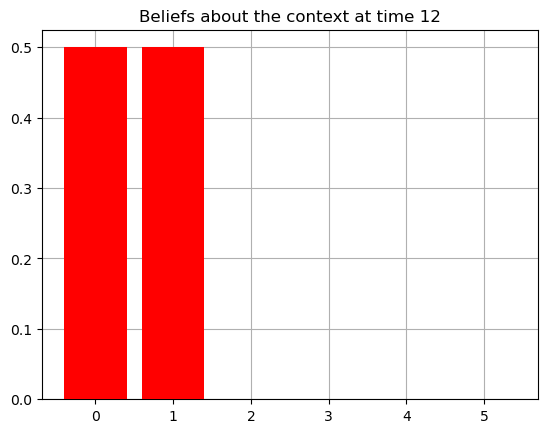

efe:[-3.51540316 -3.2168216  -6.37347394 -6.37347394]
action choice : Play-Left
Action at time 12: Play-Left
Reward at time 12: Reward
qs:[array([4.99997075e-01, 4.99997075e-01, 5.17896387e-13, 2.92506273e-06,
        5.17896387e-13, 2.92506273e-06])
 array([1.39581394e-32, 1.00000000e+00, 1.39581394e-32, 1.39581394e-32])]


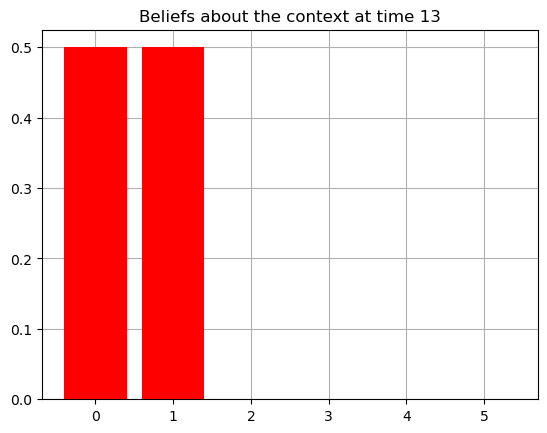

efe:[-3.51540316 -3.21680199 -6.3734884  -6.3734884 ]
action choice : Play-Left
Action at time 13: Play-Left
Reward at time 13: Reward
qs:[array([4.99998842e-01, 4.99998842e-01, 6.20048266e-14, 1.15774032e-06,
        6.20048266e-14, 1.15774032e-06])
 array([1.39580477e-32, 1.00000000e+00, 1.39580477e-32, 1.39580477e-32])]


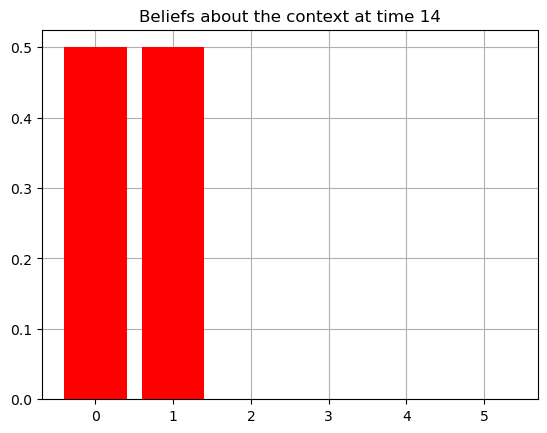

efe:[-3.51540316 -3.21679423 -6.37349413 -6.37349413]
action choice : Play-Left
Action at time 14: Play-Left
Reward at time 14: Reward


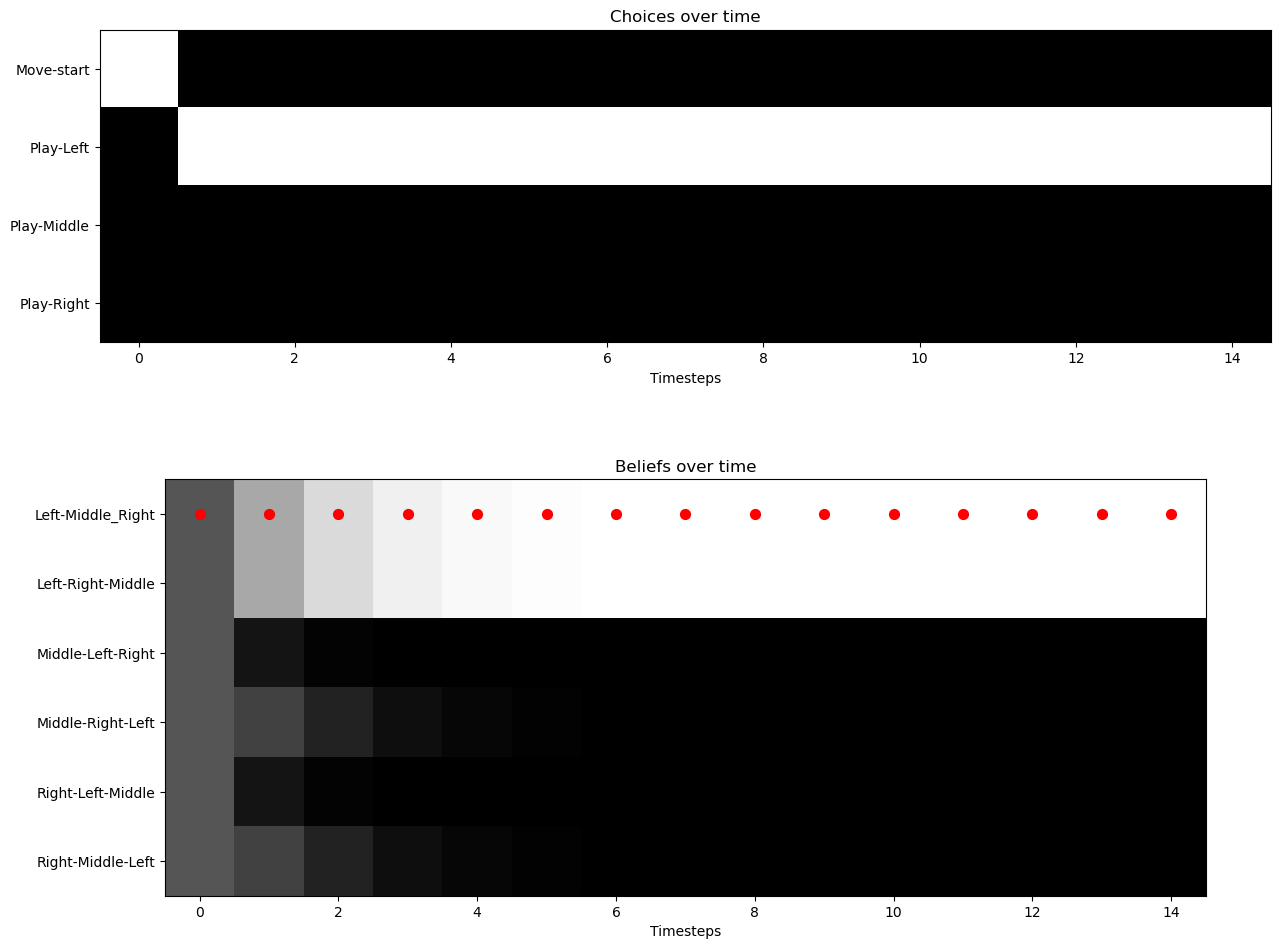

In [73]:
p_reward_env = 1.0 
T = 15
my_agent = Agent(A=A, B=B, C=C, D=D, E=E,action_selection='deterministic')
env = BanditTask(context = 'Left-Middle-Right')
choice_hist, belief_hist, context_hist = run_active_inference_loop(my_agent, env, T = T, verbose = True)
plot_choices_beliefs(choice_hist, belief_hist, context_hist)